In [1]:
import sys
import argparse
import os
import numpy as np
from scipy.signal import get_window
from skimage.util import view_as_windows
from utilities.config_handler import get_config
from utilities.visualization import plot_spectogram
from utilities.learning import split_train_validation, train_model, predict_ae_error_vectors
from utilities.detection import detect_reconstruction_anomalies_median,plot_spectogram_anomalies
from utilities.preprocessing import  add_noise,load_fft_test_data ,load_fft_train_data,  reshape_to_blocks,persist_object\
    ,load_object,persist_val_stat, load_val_stat ,get_xhdr_sample_rate , compute_fft_train_data , load_raw_data , compute_fft_train_data , trim_iq_basic_block, complex2power
import matplotlib.pyplot as plt
from sklearn import mixture
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics.pairwise import pairwise_distances_argmin_min
from scipy.stats import entropy
from scipy.fftpack import fft,rfft,fftshift
%matplotlib inline

Using TensorFlow backend.


In [2]:
parser = argparse.ArgumentParser()
parser.prog = 'Spectrum Anomaly Detection'
parser.description = 'Use this command parser for training or testing the anomaly detector'
parser.add_argument('-m', '--mode', help='train or test mode', choices=['train', 'test'])
parser.add_argument('-d', '--data-dir', help='I/Q recording directory')
parser.add_argument('-w', '--weights-path', help='path for trained weights')


sys.argv = "-m train -d iq_data/CELL/anomal/CELL_SWP_NF_20MHz_50us_10dB -w model/baseline_cepstrum".split()
namespace = parser.parse_args(sys.argv)
if not namespace.data_dir and namespace.mode == 'train':
    parser.error('the -d arg must be present when mode is train')
if not namespace.weights_path and namespace.mode == 'train':
    parser.error('the -w arg must be present when mode is train')

if not namespace.data_dir and namespace.mode == 'test':
    parser.error('the -d arg must be present when mode is test')
if not namespace.weights_path and namespace.mode == 'test':
    parser.error('the -w arg must be present when mode is test')

In [3]:
conf=get_config()
gpus = conf['gpus']
lr=conf['learning']['ae']['lr']
validation_split = conf['learning']['ae']['validation_split']
train_params = conf['learning']['ae']
rbw_set = conf['preprocessing']['ae']['rbw_set']
feature_names = conf['preprocessing']['ae']['feature_names']
fft_window_name = conf['preprocessing']['ae']['window']

train = namespace.mode == 'train'


atom_height = 1
fraction = 0.2
num_clusters = 1000
data_dir = namespace.data_dir

f_s = get_xhdr_sample_rate(data_dir)
test_window_time = 10e-6
cv_types = ['diag']

assert len(data_dir) != 0
dataset_name = str.split(data_dir, '/')[1]
recording_name = str.split(data_dir,'/')[-1]

In [4]:
for rbw in rbw_set:
    weights_dir = "_".join((dataset_name, str(rbw)))
    weights_path = os.path.join(namespace.weights_path, weights_dir)
    
    sample_rate = get_xhdr_sample_rate(data_dir)
    iq_data = load_raw_data(data_dir)
    iq_data = trim_iq_basic_block(iq_data , sample_rate)
    freqs, time, fft_train = compute_fft_train_data(iq_data,sample_rate,rbw,weights_path)

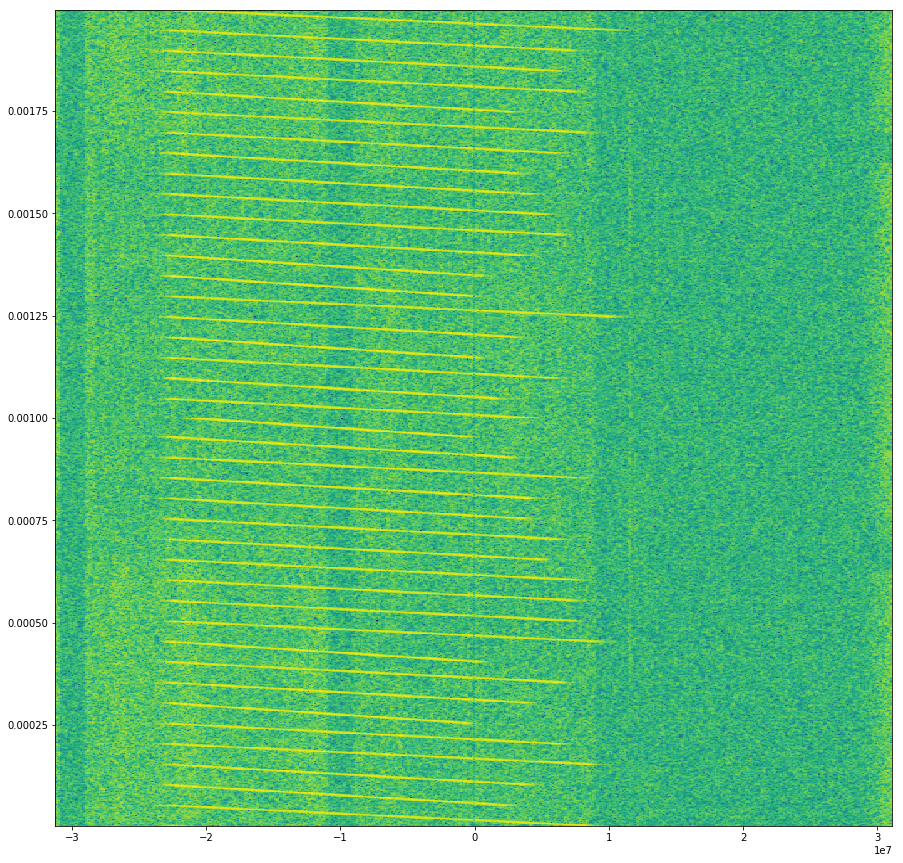

In [5]:
plot_spectogram(fft_train,freqs,time)

In [6]:
def compute_frequency_spectrum(freq):
    num_samples = len(freq)
    freq = freq - np.mean(freq)
    window = get_window(fft_window_name, num_samples)
    fft_data = ((rfft(window*freq)))
    return fft_data

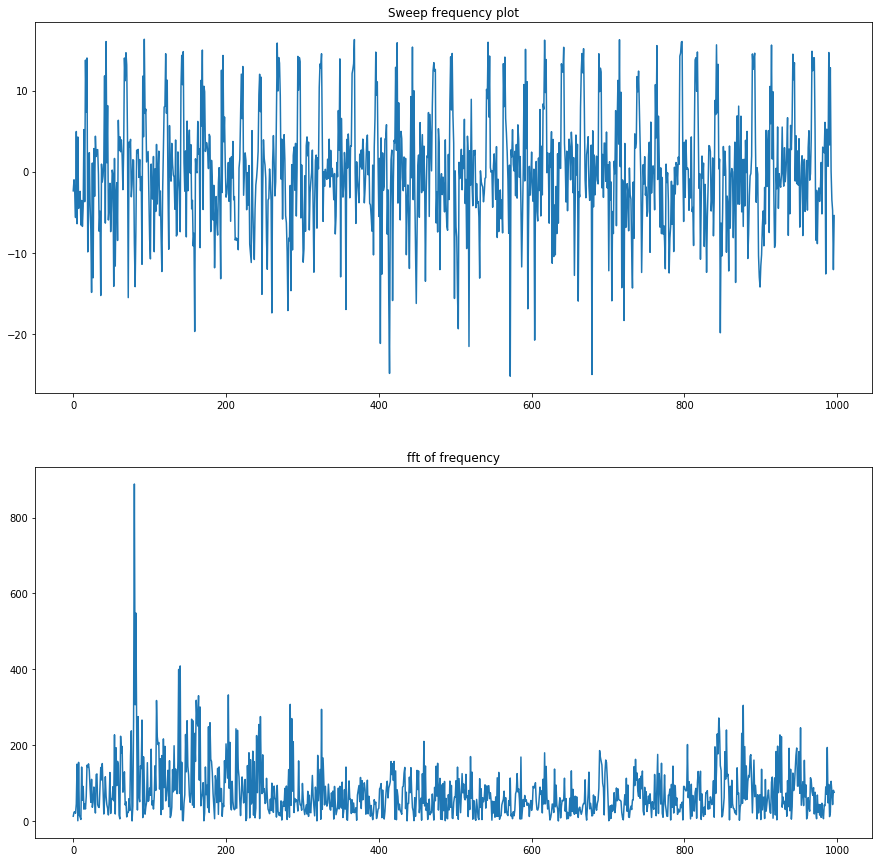

In [7]:
sweep_freq = fft_train[:,250] - np.mean(fft_train[:,250])
fig , (ax1 , ax2) = plt.subplots(2,1,figsize=(15,15))
cepstrum_sample_plot_path = os.path.join(data_dir,"cepstrum_sample.png")
ax1.plot(sweep_freq)
ax1.set_title('Sweep frequency plot')
ax2.plot(np.abs(compute_frequency_spectrum(sweep_freq)))
ax2.set_title('fft of frequency')
plt.savefig(cepstrum_sample_plot_path)
plt.show()

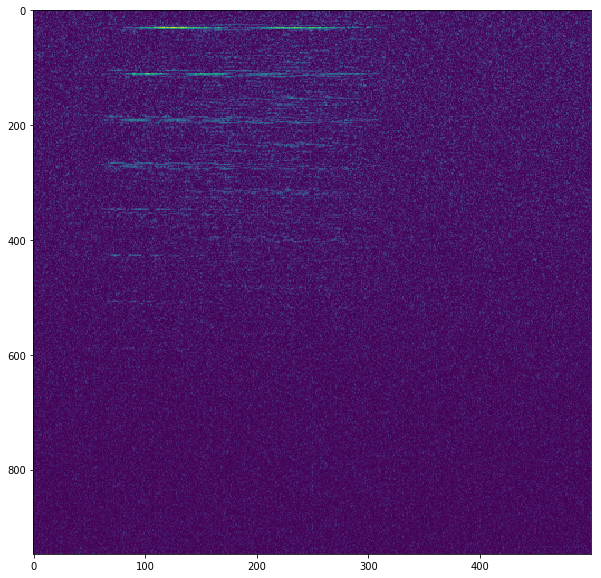

In [8]:
cepstrum_train = np.abs(np.apply_along_axis(compute_frequency_spectrum,0,fft_train))
cepstrum_train = cepstrum_train[50:] # removing the zero frequency
f,ax = plt.subplots(figsize=(10,10))
ax.imshow(cepstrum_train,aspect='auto')
plt.show()

In [9]:
cepstrum_mean = np.mean(cepstrum_train,axis=1)

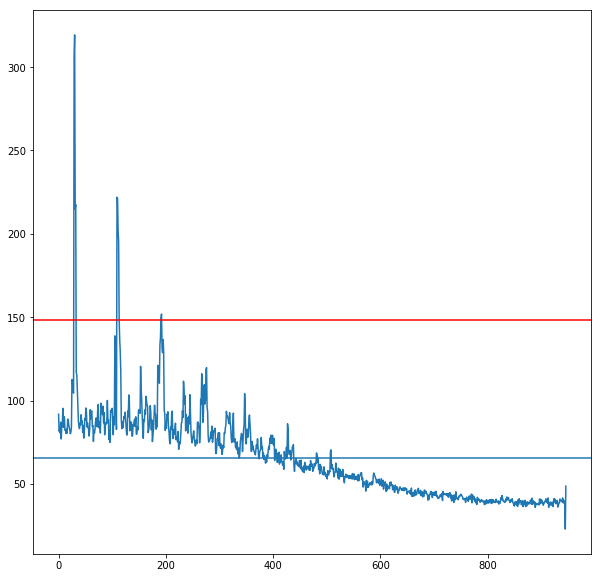

In [10]:
plt.figure(figsize=(10,10))
cepstrum_mean_plot_path = os.path.join(data_dir,"cepstrum_mean.png")
plt.plot(cepstrum_mean)
plt.axhline(np.mean(cepstrum_mean))
plt.axhline(np.mean(cepstrum_mean) + 3*np.std(cepstrum_mean),color='r')
plt.savefig(cepstrum_mean_plot_path)
plt.show()